# FUTURE DIRECTIONS

Throughout this book we've explored the powerful capabilities of transformers across a wide range of NLP tasks. In this final chapter, we'll shift our perspective and look at some of the current challenges with these models and the research trends that are trying to overcome them. In the first part, we explore the topic of scaling up transformers, both in terms of model and corpus size. Then, we turn our attention toward various techniques that have been proposed to make the self-attention mechanism more efficient. Finally, we explore the emerging and exciting field of *multimodal transformers*, which can model inputs across multiple domains like text, images, and audio.

## 1 - Scaling Transformers

In 2019, the researcher Richard Sutton wrote a provocative essay entitled ["The Bitter Lesson"](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) in which he argued that:

"
The biggest lesson that can be read from 70 years of AI research is that general methods that leverage computation are ultimately the most effective, and by a large margin…. Seeking an improvement that makes a difference in the shorter term, researchers seek to leverage their human knowledge of the domain, but the only thing that matters in the long run is the leveraging of computation. These two need not run counter to each other, but in practice they tend to…. And the human-knowledge approach tends to complicate methods in ways that make them less suited to taking advantage of general methods leveraging computation.
"

The essay provides several historical examples, such as playing chess or Go, where the approach of encoding human knowledge within AI systems was ultimately outdone by increased computation. Sutton calls this the "bitter lesso" for the AI research field:

"
We have to learn te bitter lesson that building in how we think we think does not work in the long run... One thing that should be learned from the bitter lesson is the great power of general purpose methods, of methods that continue to scale with increased computation even as the available computation becomes very great. The two methods that seem to scale arbitrarily in this way are *search* and *learning*
"

There are now signs that a similar lesson is at play with transformers; **while many of the early BERT and GPT descendatns focused on tweaking the architecture or pretraining objectives, the best-performing models in mid-2021, like GPT-3, are essentially basic scaled-up versions of the original models without many architectural modifications**. 

<table>
    <tr>
        <td><img title="" src="images_ch11/bitter_lesson_transformers.png" alt="" width="700" data-align="center"></td>
    </tr>
</table>

This dramatic growth is motivated by empirical evidence that large language models perform better on downstream tasks and that interesting capabilities such as zero-shot  and few-shot learning emerge in the 10- to 100 billion parameter range.  However, the number of parameters is not the only factor that affects model performance; the amount of compute and training data must also be scaled in tandem to train these monsters. Given that large language models like GPT-3 are estimated to cost $4.6 million to train, it is clearly desirable to be able to estimate the model's performance in advance. Somewhat surprisingly, the performance of language models appears to obey a *power law relationship* with model size and other factors that is codified in a swt of scaling laws, see [Kaplan et al. (2020)](https://arxiv.org/abs/2001.08361) and [Hoffman et al. (2022)](https://arxiv.org/abs/2203.15556) [Chinchilla].

As a summary, while Kaplan said that wee needed around 1.7 tokens per parameter, the Chinchilla paper showed that we probably needed around 20 text tokens per parameter. This idea has been later "confirmed" by smaller models that have been trained for longer, with more data, and of higher quality (e.g., LLaMA-2, MISTRAL-7B).

### 1.1 - Challenges with scaling


In addition to these studies, here are a few of the biggest challenges we are likely to encounter when scaling language models (i.e., "just adding more layers"):

* **Infraestructure**. Provisioning and managing infraestructure that potentially spans hundred or thousands of nodes with as many GPUs is not for the faint-hearted. Are the required number of nodes available? Is communication between nodes a bottleneck? Tackling these issues requires a very different skill set than that found in most data science teams, and typically involves specialized engineers familiar with running large-scale, distributed experiments.

* **Cost**. Most ML practitioners have experienced the feeling of waking up in the middle of the night in a cold sweat, remembering they forgot to shut down that fancy GPU on the cloud. This feeling intensifies when running large-scale experiments, and most companies cannot afford the teams and resources necessary to train models at the largest scales. Training a single GPT-3 sized model can cost several millione dollars, which is not affordable for every company.

* **Dataset curation**. A model is only as good as the data it is trained on. Training large models requires large, high-quality datasets. When using terabytes of text data it becomes harder to make sure the dataset contains high quality text, and even preprocessing becomes challenging. Furthermore, one needs to ensure that there is a way to control biases like sexism and racism that these language models can acquire when trained on large-scale webtext corpora. Another type of consideration revolves around licensing issues with the training data and personal information that can be embedded in large text datasets.

* **Model evaluation**. Once the model is trained, the challenges don't stop. Evaluating the model on downstream tasks again requires time and resources. In addition, you'll want to prove the model for biased and toxic generations, even if you are confident you created a clean dataset. These steps take time and need to be carried out thoroughly to minimize the risk of adverse effects later on.

* **Deployment**. Finally, serving large language models also poses a significant challenge. In Chapter 8, we looked at a few approaches, such as distillation, pruning, and quantization, to help with these issues. However, this may not be enough if you are starting with a model that is hundreds of gigabytes in size. Hosted services such as OpenAI, HuggingFace Inference API, Azure, etc. are designed to help companies that cannot or do not want to deal with these deployment challenges.

## 2 - Attention Please!

We've seen throughout this book that the self-attention mechanism plays a central role in the architecture of transformers; after all, the original Transformer paper is called "Attention is all you need"! However, there is a kye challenge associated with self-attention: since the weights are generated from pairwise comparisons of all the tokens in a sequence, this layer becomes a computational bottleneck when trying to process long documents or apply transformers to domains like speech processing or computer vision. In terms of time and memory complexity, the self-attention layer of the Transformer architecture naively scales like $\mathcal{O}(n^{2})$, where $n$ is the length of the sequence.

----

**Note:** Although standard implementations of self-attention have $\mathcal{O}(n^{2})$ time and memory complexity, [a recent paper by Google researchers](https://arxiv.org/pdf/2112.05682.pdf) shows that **the memory complexity can be reduced to** $\mathcal{O}(\log n)$ via a simple reordering of the operations.

----

As a result, much of the recent research on Transformers has focused on making self-attention more efficient. Some of the research directions are broadly clustered in the following Figure:

<table>
    <tr>
        <td><img title="" src="images_ch11/self_attention_research.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

A common pattern is to make attention more efficient by introducing sparsity into the attention mechanism or by applying kernels to the attention matrix. Let's take a quick look at some of the most popular approaches to make self-attention more efficiente, starting with sparsity.

### 2.1 - Sparse Attention

One way to reduce the number of computations that are performed in the self-attention layer is to simply limit the number of query-key pairs that are generated according to some predefined pattern. There have been many sparsity patterns explored in the literature, but most of them can be decomposed into a handful of "atomic" patterns illustrated in the following Figure:

<table>
    <tr>
        <td><img title="" src="images_ch11/sparse_attention_patterns.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

We can describe these patterns as follows:

* **Global attention**. Defines a few special tokens in the sequence that are allowed to attend to all other tokens.
* **Band attention**. Computes attention over a diagonal band.
* **Dilated attention**. Skips some query-key pairs by using a dilated window with gaps.
* **Random attention**. Randomly samples a few keys for each query to compute attention scores.
* **Block local attention**. Divides the sequence an restricts attention within these blocks.

In practice, most transformer models with sparse attention use a mix of the atomic sparsity patterns to generate the final attention matrix. As illustrated by the following Figure, models like [Longformer](https://huggingface.co/allenai/longformer-base-4096) use a mix of global and band attention, while [BigBird](https://huggingface.co/google/bigbird-roberta-base) adds random attention to the mix. 

Introducing sparsity into the attention matrix enables these models to process much longer sequences; in the case of Longformer and BigBird, the maximum sequence length is 4096 tokens, which is 8 times larger than BERT!

<table>
    <tr>
        <td><img title="" src="images_ch11/sparse_transformer_models.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

It is also possible to *learn* the sparsity pattern in a data-driven manner. The basic idea behind such approaches is to cluster the tokens into chunks. For example, [Reformer](https://huggingface.co/google/reformer-crime-and-punishment) uses a hash function to cluster similar tokens together.

### 2.2 - Linearized Attention

An alternative way to make self-attention more efficient is to change the order of operations that are involved in computing the attention scores. Recall that to compute the self-attention scores of the queries and keys we need a similarity function, which for the transformer is just a simple dot product. However, for a general similarity function $\text{sim}(q_{i}, k_{j})$ we can express the attention outputs as the following equation:

$$
y_{i} = \sum_{j} \frac{\text{sim}(Q_{i}, K_{j})}{\sum_{k} \text{sim}(Q_{i}, K_{k})}V_{j}
$$

The trick behind linearized attention mechanisms is to express the similarity funciton as a kernel function that decomposes the operation into two piece:

$$
\text{sim}(Q_{j}, K_{j}) = \phi(Q_{i})^{T} \phi(K_{j})
$$

where $\phi$ is typically a high-dimensional feature map. Since $\phi(Q_{i})$ is independent of $j$ and $k$, we can pull it under the sums to write the attention outputs as follows:

$$
y_{i} = \frac{\phi(Q_{i})^{T} \sum_{j} \phi(K_{j})V_{j}^{T}}{\phi(Q_{i})^{T} \sum_{k} \phi(K_{k})}
$$

By first computing $\sum_{j} \phi(K_{j})V_{j}^{T}$ and $\sum_{k} \phi(K_{k})$, we can effectively linearize the space and time complexity of self-attention! The comparison between the two approaches is illustrated in the following Figure. Popular models that implement linearized self-attention include [Linear Transformer (Katharopoulos et al., 2020)](https://arxiv.org/abs/2006.16236) and [Performer (Choromanski et al., 2020)](https://arxiv.org/abs/2009.14794).

<table>
    <tr>
        <td><img title="" src="images_ch11/linear_transformer_performer.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

## 3 - Going Beyond text

Using text to train language models has been the driving force behind the success of transformer language models, in combination with transfer learning. On the one hand, text is abundant and enables self-supervised training of large models. On the other hand, textual tasks such as classification and question answering are common and developing effective strategies for them allows us to address a wide range of real-world problems.

However, there are limits to this approach, including:

* **Human reporting bias**. The frequences of events in text may not represent their true frequences. A model solely trained on text from the internet might have a very distorted image of the world.
* **Common sense**. Common sense is a fundamental quality of human reasoning, but is rearely written down. As such, language models trained on text might know many facts about the world, but lack basic common-sense reasoning.
* **Facts**. A probabilistic model cannot store facts in a realiable way and can produce text that is factually wrong. Similarly, such models can detect named entities, but have no direct way to access information about them.
* **Modality**. Language models have no way to connect to other modalities that could address the previous points, such as audio or visual signals or tabular data.

So, if we could solve the modality limitations we could potentially address some of the others as well. Recently there has been a lot of progress in pushing transformers to new modalities, and even building multimodal models. In this section, we'll highlight a few of these advances.

### 3.1 - Vision

Vision has been the stronghold of convolutional neural networks (CNNs) since they kickstarted the deep learning revolution. More recently, transformers have begun to be applied to this domain and to achieve efficiency similar to or better than CNNs. Let's have a look at a few examples.

#### iGPT

Inspired by the success of the GPT family of models with text, iGPT (short for image GPT) applies the same methods to images. By viewing images as sequences of pixels, iGPT uses the GPT architecture and autoregressive pretraining objective to predict the next pixel values. Pretraining on large image datasets enables iGPT to "autocomplete" partial images. It also achieves performan results on classification tasks when a classification head is added to the model.

<table>
    <tr>
        <td><img title="" src="images_ch11/igpt.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

### ViT

We saw that iGPT follows closely the GPT-style architecture and pretraining procedure. Vision Transformer (ViT) is a BERT-style take on transformers for vision. First the image is split into smaller patches, and each of these patches is embedded with a linear projection. The results strongly resemble the token embeddings in BERT, and what follows is virtually identical. The patch embeddings are combined with position embeddings and then fed through an ordinary transformer encoder. During pretraining some of the patches are masked or distorted, and the objective is to predict the average color of the masked patch.

<table>
    <tr>
        <td><img title="" src="images_ch11/vit.png" alt="" width="600" data-align="center"></td>
    </tr>
</table>

Although this approach did not produce better results when pretrained on the standard ImageNet dataset, it scaled significantly better than CNNs on larger datasets.

#### Video models

A ntaural extension of image models is video models. In addition to the spatial dimensions, videos come with a temporal dimension. This makes the task more challenging as the volume of dat gets much bigger and one needs to deal with the extra dimension. Models such as [TimeSformer (Bertasius et al., 2021)](https://arxiv.org/abs/2102.05095) introduce a spatial and temporal attention mechanism to account for both. In the future, such models can help build tools for a wide range of tasks such as classification or annotation of video sequences.

### 3.2 - Tables

A lot of data, such as customer data within a company, is stored in structured databases instead of as raw text. In Chapter 7, we saw that with Question-answering models we can query text with a question in natural text. Wouldn't it be nice if we could do the same with tables?

<table>
    <tr>
        <td><img title="" src="images_ch11/table_qa.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

TAPAS (short for Table Parser) to the rescue! This model applies the Transformer architecture to tables by combining the tabular information with the query, as illustrated in the following Figure:

<table>
    <tr>
        <td><img title="" src="images_ch11/tapas.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

Let's look at an example of how TAPAS works in practice. We have created a fictious version of this book's table of contents. It contains the chapter number, the name of the chapter, as well as the starting and ending pages of the chapters:

In [1]:
book_data = [
    {"chapter": 0, "name": "Introduction", "start_page": 1, "end_page": 11},
    {"chapter": 1, "name": "Text classification", "start_page": 12, "end_page": 48},
    {"chapter": 2, "name": "Named Entity Recognition", "start_page": 49, "end_page": 73},
    {"chapter": 3, "name": "Question Answering", "start_page": 74, "end_page": 120},
    {"chapter": 4, "name": "Summarization", "start_page": 121, "end_page": 140},
    {"chapter": 5, "name": "Conclusion", "start_page": 141, "end_page": 144}
]

We can also easily add the number of pages each chapter has with the existing fields. In order to play nicely with the TAPAS model, we need to make sure that all columns are of type `str`:

In [2]:
import pandas as pd

table = pd.DataFrame(book_data)
table['number_of_pages'] = table['end_page']-table['start_page']
table = table.astype(str)
table

,chapter,name,start_page,end_page,number_of_pages
0,0,Introduction,1,11,10
1,1,Text classification,12,48,36
2,2,Named Entity Recognition,49,73,24
3,3,Question Answering,74,120,46
4,4,Summarization,121,140,19
5,5,Conclusion,141,144,3


To make things really easy, we can use the `table-question-answering` pipeline and then pass some queries to extract the answers:

In [3]:
from transformers import pipeline

table_qa = pipeline("table-question-answering")
queries = [
    "What's the topic in chapter 4?",
    "What is the total number of pages?",
    "On which page does the chapter about question-answering start?",
    "How many chapters have more than 20 pages?"
]
preds = table_qa(table, queries)

for query, pred in zip(queries, preds):
    print(query)
    if pred["aggregator"] == "NONE":
        print("Predicted answer: " + pred["answer"])
    else:
        print("Predicted answer: " + pred["answer"])
    print('='*50)

/anaconda/envs/zero-touch-coding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to google/tapas-base-finetuned-wtq and revision 69ceee2 (https://huggingface.co/google/tapas-base-finetuned-wtq).
Using a pipeline without specifying a model name and revision in production is not recommended.


What's the topic in chapter 4?
Predicted answer: Summarization
What is the total number of pages?
Predicted answer: SUM > 10, 36, 24, 46, 19, 3
On which page does the chapter about question-answering start?
Predicted answer: AVERAGE > 74
How many chapters have more than 20 pages?
Predicted answer: COUNT > 1, 2, 3


For the first chapter, the model predicted exactly one cell with no aggregation. If we look at the table, we see that the answer is in fact correct. In the next example the
model predicted all the cells containing the number of pages in combination with the sum aggregator, which again is the correct way of calculating the total number of
pages. The answer to question three is also correct; the average aggregation is not necessary in that case, but it doesn’t make a difference. Finally, we have a question
that is a little bit more complex. To determine how many chapters have more than 20 pages we first need to find out which chapters satisfy that criterion and then count
them. It seem that TAPAS again got it right and correctly determined that chapters 1, 2, and 3 have more than 20 pages, and added a count aggregator to the cells.

-----

**Note:** As of 2023-2024, with big LLMs, this kind of models that work with small tables are not that useful anymore, but the ideas are interesting

----

### 3.3 - Multimodal

So far we've looked at extending transformers to a single new modality. TAPAS is arguably multimodal since it combines text and tables, but the table is also treated as text. In this section we examine transformers that combine two modalities at once: audio plus text and vision plus text.

#### Speech-to-Text

Although being able to use text to interface with a computer is a huge step forward, using spoken language is an even more natural way for us to communicate. You can see this trend in industry, where applications such as Siri and Alexa are on the rise and becoming progressively more useful. Also, for a large fraction of the population, writing and reading are more challenging than speaking. So, being able to process and understand audio is not only convenient, but can help many people access more information. A common task in this domain is *automatic speech recognition* (ASR), which converts spoken words to text and enables voice technologies like Siri to answer questions like "What is the weather like today?"

The [wav2vec 2.0 family of models](https://huggingface.co/models?search=wav2vec2+facebook) ([Conneau et al., 2020](https://arxiv.org/abs/2006.13979)) are one of the most recent developments in ASR: they use a transformer layer in combination with a CNN. By leveraging unlabeled data during pretraining, these models achieve competitive results with only a few minutes of labeled data.

<table>
    <tr>
        <td><img title="" src="images_ch11/wav2vec.png" alt="" width="600" data-align="center"></td>
    </tr>
</table>

This family of models is integrated in HuggingFace. Let's load a pretrained model that was trained on 960 hours of speech audio:

In [4]:
asr = pipeline("automatic-speech-recognition")

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To apply this model to some audio files we'll use the ASR subset of the [SUPERB dataset](https://huggingface.co/datasets/superb), which is the same dataset the model was pretrained on. Since the dataset is quite large, we'll just load one example for our demo purposes:

`pip install soundfile`

`pip install librosa`

In [7]:
from datasets import load_dataset
ds = load_dataset("superb", "asr", split="validation[:1]")
print(ds[0])

Found cached dataset superb (/home/azureuser/.cache/huggingface/datasets/superb/asr/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e)


{'file': '/home/azureuser/.cache/huggingface/datasets/downloads/extracted/0dc37a493dfeb8a0b2250abb6d5ad5e415c15439cc497583fbd3fd061c422e35/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac', 'audio': {'path': '/home/azureuser/.cache/huggingface/datasets/downloads/extracted/0dc37a493dfeb8a0b2250abb6d5ad5e415c15439cc497583fbd3fd061c422e35/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac', 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
       0.0010376 ]), 'sampling_rate': 16000}, 'text': 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL', 'speaker_id': 1272, 'chapter_id': 128104, 'id': '1272-128104-0000'}


Here we can see that the audio in the `file` column is stored in the FLAC coding format, while the expected transcription is given by the `text` column. To convert the audio to an array of floats, we can use the [SoundFile library](https://pypi.org/project/soundfile/) to read each file in our dataset with `map()`:

In [13]:
import soundfile as sf
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch
ds = ds.map(map_to_array)

Since we are using Jupyter, we can easily play the sound files with the following `IPython` widgets:

In [14]:
from IPython.display import Audio
display(Audio(ds[0]['speech'], rate=16000))

Finally, we can pass the inputs to the pipeline and inspect the prediction:

In [20]:
import numpy as np

pred = asr(np.array(ds[0]["speech"]))
print(pred)

{'text': 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'}


This transcription seems to be correct. We can see that some punctuation is missing, but this is hard to get from audio alone and could be added in a postprocessing step.
With only a handful of lines of code we can build ourselves a state-of-the-art speech-to-text application!

Building a model for a new language still requires a minimum amount of labeled data, which can be challenging to obtain, especially for low-resource languages. Soon after the release of wav2vec 2.0, [a paper describing a method named wav2vec-U was published](https://arxiv.org/abs/2105.11084). In this work, a combination of clever clustering and GAN training is used to build a speech-to-text model using only independent unlabeled speech and unlabeled text data. no aligned speech and text data is required at all, which enables the training of highly performant speech-to-text models for much larger spectrum of languages.

<table>
    <tr>
        <td><img title="" src="images_ch11/wav2vec_u.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

#### Vision and Text

Vision and text are another natural pair of modalities to combine since we frequently use language to communicate and reason about the contents of images and videos. In addition to the vision transformers, there have been several developments in the direction of combining  visual and text information. In this section, we will look at four examples of models combining vision and text:

* VisualQA
* LayoutLM
* DALL-e
* CLIP

##### VQA

Visual Question Answering (VQA) is the task of answering open-ended questions based on an image. The input to models supporting this task is typically a combination of an image and a question, and the output is an answer expressed in natural language.

Models such as [LXMERT (Tan & Bansal, 2019)](https://arxiv.org/abs/1908.07490) and [VisualBERT (Li et al., 2019)](https://arxiv.org/abs/1908.03557) use vision models like ResNets to extract features from the pictures and then use transformer encoders to combine them with the natural questions and predict an answer.

<table>
    <tr>
        <td><img title="" src="images_ch11/vqa.png" alt="" width="600" data-align="center"></td>
    </tr>
</table>

##### LayoutLM

Analyzing scanned business documents like receipts, invoices, or reports is another area where extracting visual and layout information can be useful way to recognize text fields of interest. Here the LayoutLM family of models are the current state of the art. They use an enhanced Transformer architecture that receives three modalities as input:
* text
* image
* layout

Accordingly, as shown in the following figure, there are embedding layers associated with each modality, a spatially aware self-attention mechanism, and a mix of image and text/image pretraining objectives to align the different modalities.

By pretraining on millions of scanned documents, LayoutLM models are able to transfer to various downstream tasks in a manner similar to BERT for NLP.

<table>
    <tr>
        <td><img title="" src="images_ch11/layoutlm_architecture.png" alt="" width="800" data-align="center"></td>
    </tr>
</table>

##### DALL-E

A model that combines vision and text for generative tasks is DALL-E. It uses the GPT architecture and atuoregressive modeling to generate images from text. Inspired by iGPT, it regards the words and pixels as one sequence tokens and is thus able to continue generating an image from a text prompt:

<table>
    <tr>
        <td><img title="" src="images_ch11/dalle.png" alt="" width="700" data-align="center"></td>
    </tr>
</table>

##### CLIP

CLIP also combines text and vision but is designed for supervised tasks. Its creators constructed a dataset with 400 million image/caption pairs and used contrastive learning to pretrain the model. The CLIP architecture consists of a text and an image encoder (both Transformers) that create embeddings of the captions and images. A batch of images with captions is sampled, and the contrastive objective is to maximize the similarity of the embeddings (as measured by the dot product) of the corresponding pair while minimizing the similarity of the rest.

In order to use the pretrained model for classification, the possible classes are embedded with the text encoder, similar to zero-shot learning. Then the embeddings of all the classes are compared to the image embedding that we want to classify, and the class with the highest similarity is chosen.

<table>
    <tr>
        <td><img title="" src="images_ch11/clip.png" alt="" width="700" data-align="center"></td>
    </tr>
</table>

the zero-shot image classification performance of CLIP is remarkable and competitive with fully supervised trained vision models, while being more flexible with regard to new classes. CLIP is also fully integrated in HuggingFace, so we can try it out.

For image-to-text tasks, we instantiate a *processor* that consists of a *feature extractor* and a *tokenizer*. The role of the feature extractor is convert the image into a form suitable for the model, while the tokenizer is responsible for decoding the model's predictions into text:

In [21]:
from transformers import CLIPProcessor, CLIPModel
clip_ckpt = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(clip_ckpt)
processor = CLIPProcessor.from_pretrained(clip_ckpt)

Then we need a fitting image to try it out. What would be better suited than a picture of Optimus Prime?

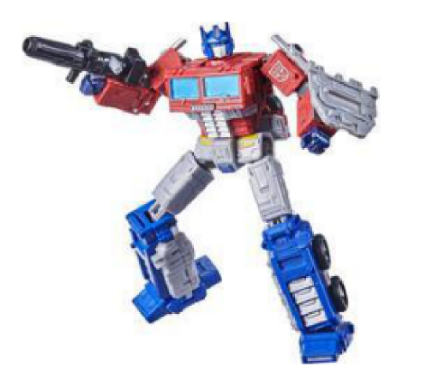

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("images_ch11/optimus_prime.png")
plt.imshow(image)
plt.axis("off")
plt.show()

Next, we set up the texts to compare the image against and pass it through the model:

In [26]:
import torch

texts = ["a photo of a transformer", "a photo of a robot", "a photo of agi"]
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)
probs

tensor([[0.9394, 0.0556, 0.0050]])